# Ludo Project

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [6]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  image = PIL.Image.fromarray(a)
  new_image = image.resize((250, 400))
  display(new_image)

In [7]:
#Video.from_file('videos\IMG_1912.mp4')
board = cv2.VideoCapture('videos\IMG_1912.mp4')
if board.isOpened():
    print('Video loaded')

board_width = int(board.get(3))
board_height = int(board.get(4))

print(board_height, board_width)

board_fps = board.get(cv2.CAP_PROP_FPS)
print(board_fps)

Video loaded
1920 1080
29.97002997002997


In [8]:
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = board.read()
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y:y+h, x:x+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

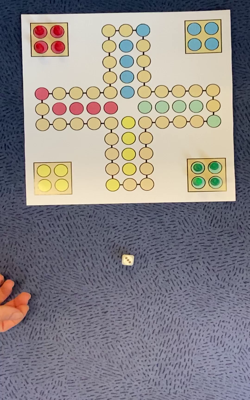

In [15]:
imshow(frame)

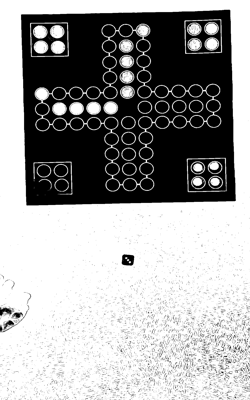

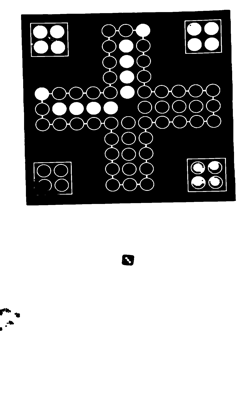

[[[ -1  -1   1  -1]
  [  2  -1  -1   0]
  [  3   1  -1   0]
  [  5   2   4   0]
  [ -1  -1  -1   3]
  [  6   3  -1   0]
  [  7   5  -1   0]
  [ 11   6   8   0]
  [  9  -1  -1   7]
  [ 10   8  -1   7]
  [ -1   9  -1   7]
  [ -1   7  12   0]
  [ 13  -1  -1  11]
  [ 14  12  -1  11]
  [ 15  13  -1  11]
  [ 16  14  -1  11]
  [ 17  15  -1  11]
  [ 18  16  -1  11]
  [ 20  17  19  11]
  [ -1  -1  -1  18]
  [ 22  18  21  11]
  [ -1  -1  -1  20]
  [ 24  20  23  11]
  [ -1  -1  -1  22]
  [ 25  22  -1  11]
  [ 38  24  26  11]
  [ -1  -1  27  25]
  [ 30  -1  28  26]
  [ 29  -1  -1  27]
  [ -1  28  -1  27]
  [ 32  27  31  26]
  [ -1  -1  -1  30]
  [ 36  30  33  26]
  [ 34  -1  -1  32]
  [ 35  33  -1  32]
  [ -1  34  -1  32]
  [ -1  32  37  26]
  [ -1  -1  -1  36]
  [102  25  39  11]
  [ 40  -1  -1  38]
  [ 41  39  -1  38]
  [ 42  40  -1  38]
  [ 43  41  -1  38]
  [ 44  42  -1  38]
  [ 45  43  -1  38]
  [ 46  44  -1  38]
  [ 47  45  -1  38]
  [ 48  46  -1  38]
  [ 49  47  -1  38]
  [ 50  48  -1  38]


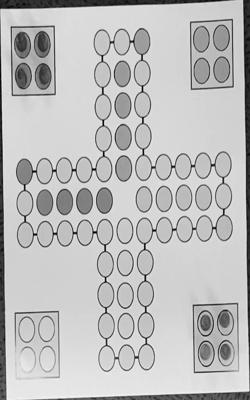

4 [-1  7 12  0]
0.9925293489861259


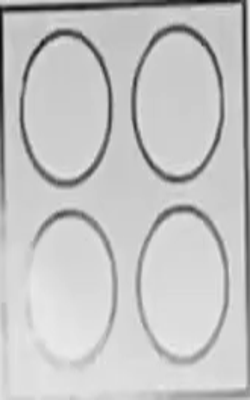

8 [25 22 -1 11]
1.0576923076923077


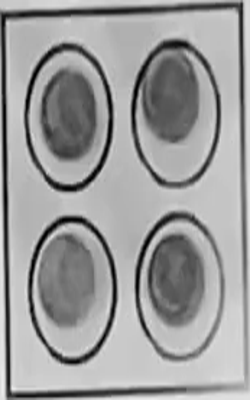

4 [38 24 26 11]
1.0484848484848486


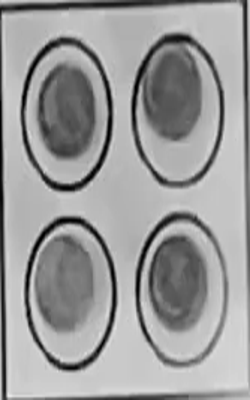

4 [-1 -1 27 25]
1.050314465408805


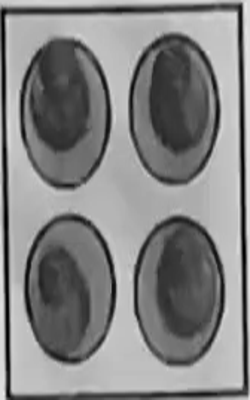

4 [116  38 103  11]
1.018181818181818


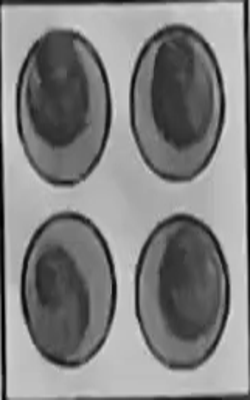

4 [ -1  -1 104 102]
1.0125786163522013


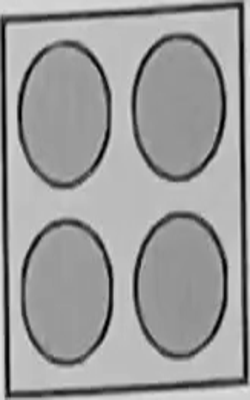

4 [ -1 102 117  11]
0.9760479041916168


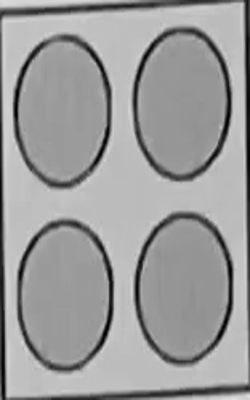

4 [ -1  -1 118 116]
0.968944099378882


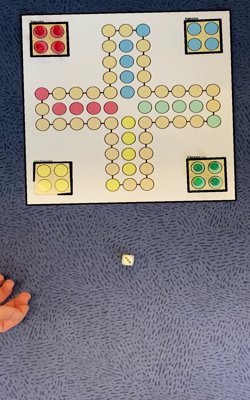

In [16]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 160, 255, cv2.THRESH_BINARY_INV)[1]
    imshow(thresh)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    imshow(close)
    # Find contours and filter using threshold area
    cnts, hierarchy = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    for contour, hier in zip(cnts, hierarchy[0]):
        # print("c", contour)
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x = approx.ravel()[0]
        y = approx.ravel()[1] - 5
        x, y , w, h = cv2.boundingRect(approx)
        aspectRatio = float(w)/h
        if  aspectRatio >0.9 and aspectRatio < 1.1 and cv2.contourArea(contour) > 100 and len(approx)< 10:
            cv2.drawContours(image, [approx], 0, (0, 0, 0), 5)
            imshow(gray[ y:y+h,x:x+w])
            print(len(approx), hier)
            print(aspectRatio)
            if aspectRatio >= 0.95 and aspectRatio < 1.05:
                cv2.putText(image, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            else:
                cv2.putText(image, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
        
        # TODO cluster into 5 subcategories: board, base1, base2, base3, base4
    imshow(image)
    


def base_recognition(frame):
    pass


def board_recognition(frame):
    pass


find_squares(frame)

In [7]:
board_track = cv2.VideoWriter('./slow_board_small_meanshift.avi', cv2.VideoWriter_fourcc(*'DIVX'), board_fps, (board_width, board_height))

board.set(cv2.CAP_PROP_POS_FRAMES, 0)
while board.isOpened():
    ret, frame = board.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x, y, w, h = track_window
        board_track.write(cv2.rectangle(frame, (x,y), (x + w,y + h), 255, 2))
    else:
        break

board_track.release()

In [5]:
!ffmpeg -hide_banner -loglevel error -i slow_board_small_meanshift.avi -y slow_board_small_meanshift.mp4

In [6]:
Video.from_file('./slow_board_small_meanshift.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')